# Decompose velocities into large-scale and mesoscale.

In order to decompose EKE into large scale and mesoscale. We first filtered the velocity fields into large-scale and mesoscale features. Then the EKE is computed for both scales. The following code shows how to reproduce it for the year 1993, but it can be extended to the full record by uncommenting cells. 

In [1]:
# Import libraries
import xarray as xr
import cmocean as cm
import cartopy.crs as ccrs

import pylab as plt
import numpy as np
# Inline plotting
%matplotlib inline

In [2]:
from dask.distributed import Client

In [3]:
from utils import area,ccrs_land,add_patches
import datetime as datetime

In [4]:
c = Client()
c

Client Scheduler: tcp://127.0.0.1:37975 Dashboard: /proxy/8787/status,Cluster Workers: 8 Cores: 48 Memory: 202.48 GB


In [5]:
from astropy import convolution

In [6]:
inputfiles='/g/data/ua8/CMEMS_SeaLevel/v2019/{0}/*.nc'
# inputfiles='path/to/AVISO+/*.nc'

# Large scale EKE

In [7]:
kernel=np.ones((1,13,13)) # 0.25*13 = 3.25, the kernel size must be an odd number.

In order to avoid issues with memory, temporary files are created to filter the velocity field. 

In [8]:
#Uncomment to generate tmp files.
for year in range(2009,2020):
    dataset_AVISO = xr.open_mfdataset(inputfiles.format(year),parallel=True)
    dataset_AVISO = dataset_AVISO.rename({'latitude':'lat','longitude':'lon'})
    u_data = dataset_AVISO.ugosa
    v_data = dataset_AVISO.vgosa
    filtered_u = u_data.copy()
    filtered_u.data = convolution.convolve(u_data,boundary='wrap', kernel = kernel, preserve_nan=True)
    filtered_v = v_data.copy()
    filtered_v.data = convolution.convolve(v_data,boundary='wrap', kernel = kernel, preserve_nan=True)
    
    filtered_u.to_netcdf('../datasets/tmp_u_large_scale_{0}.nc'.format(year))
    filtered_v.to_netcdf('../datasets/tmp_v_large_scale_{0}.nc'.format(year))

In [9]:
filtered_u = xr.open_mfdataset('../datasets/tmp_u_large_scale_*.nc',chunks={'time':1,'lon':720,'lat':720})
filtered_v = xr.open_mfdataset('../datasets/tmp_v_large_scale_*.nc',chunks={'time':1,'lon':720,'lat':720})

Compute large scale EKE coarsened into 1$\times$1 degrees.

In [10]:
rho=1025 # kg/m3
large_scale_EKE = 1/2 * rho * (filtered_u.ugosa**2 + filtered_v.vgosa**2).coarsen({'lat':4,'lon':4}).mean().compute()

In [11]:
large_scale_EKE.to_netcdf('../datasets/tmp_large_scale_EKE.nc')
# large_scale_EKE = xr.open_dataset('../datasets/tmp_large_scale_EKE.nc')

In [12]:
dataset_AVISO = xr.open_mfdataset(inputfiles.format('*'),parallel=True)
dataset_AVISO = dataset_AVISO.rename({'latitude':'lat','longitude':'lon'})

In [13]:
u_data = dataset_AVISO.ugosa
v_data = dataset_AVISO.vgosa

In [14]:
u_mesoscale = u_data - filtered_u.ugosa
v_mesoscale = v_data - filtered_v.vgosa

In [15]:
u_mesoscale

,Array,Chunk
Bytes,81.79 GB,4.15 MB
Shape,"(9861, 720, 1440)","(1, 720, 720)"
Count,138282 Tasks,19722 Chunks
Type,float64,numpy.ndarray


In [16]:
rho=1025 # kg/m3
mesoscale_EKE = 1/2 * rho * (u_mesoscale**2 + v_mesoscale**2).coarsen({'lat':4,'lon':4}).mean().compute()

In [17]:
mesoscale_EKE = xr.open_dataset('../datasets/tmp_mesoscale_EKE.nc')
# mesoscale_EKE.to_netcdf('../datasets/tmp_mesoscale_EKE.nc')

In [18]:
rolling_large_scale_EKE = large_scale_EKE.rolling(time=365,center=True).mean().compute()

In [19]:
rolling_mesoscale_EKE = mesoscale_EKE.rolling(time=365,center=True).mean().compute()

In [23]:
rolling_large_scale_EKE

<xarray.DataArray '__xarray_dataarray_variable__' (time: 9861, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [24]:
rolling_mesoscale_EKE

<xarray.DataArray (time: 9861, lat: 180, lon: 360)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * time     (time) datetime64[ns] 1993-01-01 1993-01-02 ... 2019-12-31
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

In [26]:
dataset = xr.merge([rolling_mesoscale_EKE.to_dataset(name='EKE_m'),rolling_large_scale_EKE.to_dataset(name='EKE_ls')])

In [27]:
dataset.attrs['title'] = "Eddy Kinetic Energy"
dataset.attrs['Description'] = """Eddy Kinetic Energy computed from AVISO+ altimetry products."""
dataset.attrs['Publication'] = "Dataset created for Martínez-Moreno, J. et. al. 2020: \n 'Global changes in oceanic mesoscale currents over the satellite altimetry record'"
dataset.attrs['Author'] = "Josué Martínez-Moreno"
dataset.attrs['Contact'] = "josue.martinezmoreno@anu.edu.au"

dataset.attrs['Created date'] = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")

units = [r"$m^2s^{-2}$",r"$m^2s^{-2}$"]
names = ["EKE_m","EKE_ls"]
long_names = ["Mesoscale Eddy Kinetic Energy", "Large scale Eddy Kinetic Energy"]

counter=0
for mask_name in list(dataset.data_vars):
    dataset[mask_name].attrs['units'] = units[counter]
    dataset[mask_name].attrs['name'] = names[counter]
    dataset[mask_name].attrs['long_name'] = long_names[counter]
    
    dataset[mask_name].attrs['missing_value'] = np.nan
    dataset[mask_name].attrs['valid_min'] = np.nanmin(dataset[mask_name])
    dataset[mask_name].attrs['valid_max'] = np.nanmax(dataset[mask_name])
    dataset[mask_name].attrs['valid_range'] = [np.nanmin(dataset[mask_name]),np.nanmax(dataset[mask_name])]
    
    counter+=1

In [28]:
comp = dict(zlib=True, complevel=5)
encoding = {var: comp for var in dataset.data_vars}

dataset.to_netcdf('../datasets/EKE_decomposition_timeseries.nc', encoding=encoding)

In [ ]:
!rm ../datasets/tmp*.nc

### Compute plot of mean mesoscale and large scale EKE

In [32]:
mean_large_scale_EKE = rolling_large_scale_EKE.mean("time")
mean_mesoscale_EKE = rolling_mesoscale_EKE.mean("time")

In [33]:
mean_large_scale_EKE

<xarray.DataArray '__xarray_dataarray_variable__' (lat: 180, lon: 360)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]])
Coordinates:
  * lat      (lat) float32 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float32 0.5 1.5 2.5 3.5 4.5 ... 355.5 356.5 357.5 358.5 359.5

### Plot mean large-scale and mesoscale EKE.

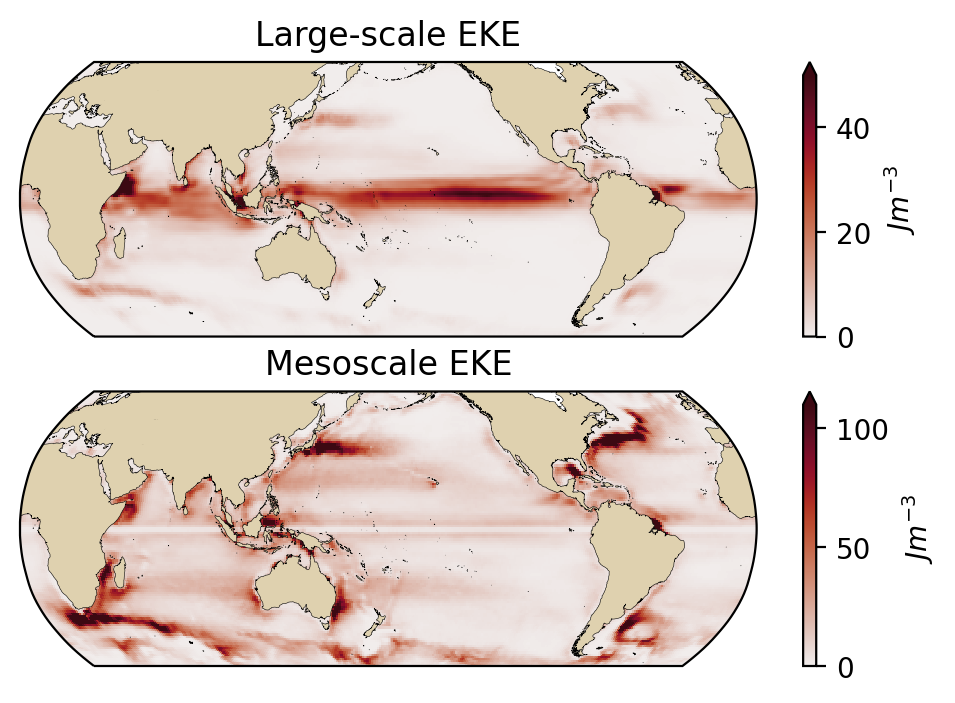

In [34]:
fig = plt.figure(figsize=(6,4), dpi=200)
ax = fig.add_subplot(2, 1, 1, projection = ccrs.Robinson(central_longitude=180))

im = mean_large_scale_EKE.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$J m^{-3}$"),
              cmap=cm.cm.amp, vmin=0, vmax=50,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Large-scale EKE')
add_patches(ax)

ax = fig.add_subplot(2, 1, 2, projection = ccrs.Robinson(central_longitude=180))

im = mean_mesoscale_EKE.plot(transform=ccrs.PlateCarree(),cbar_kwargs=dict(label="$J m^{-3}$"),
              cmap=cm.cm.amp, vmin=0, vmax=110,ax=ax)
ax.set_extent([0.1,359.99,-60, 60], crs=ccrs.PlateCarree())
ax.add_feature(ccrs_land)
ax.set_title('Mesoscale EKE')
add_patches(ax)